# Predicción de Series Temporales con Redes Neuronales

### Importar las Librerías a utilizar

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

In [111]:
### Cargamos nuestro Dataset

In [39]:
df = pd.read_csv('time_series.csv',  parse_dates=[0], header=None,index_col=0, names=['fecha','unidades'])
df.head()

,unidades
fecha,
2021-01-02,236
2021-01-03,237
2021-01-04,290
2021-01-05,221
2021-01-07,128


In [40]:
df.describe()

,unidades
count,604.000000
mean,215.935430
std,75.050304
min,51.000000
25%,171.000000
50%,214.000000
75%,261.250000
max,591.000000


In [41]:
print(df.index.min())
print(df.index.max())

2021-01-02 00:00:00
2022-11-30 00:00:00


In [42]:
try:
    print(len(df['2021']))
    print(len(df['2022']))
except:
    pass

In [43]:
meses = df.resample('M').mean()
meses

,unidades
fecha,
2021-01-31,203.923077
2021-02-28,184.666667
2021-03-31,182.964286
2021-04-30,198.960000
2021-05-31,201.185185
2021-06-30,209.518519
2021-07-31,278.923077
2021-08-31,316.000000
2021-09-30,222.925926


## Visualizaciones

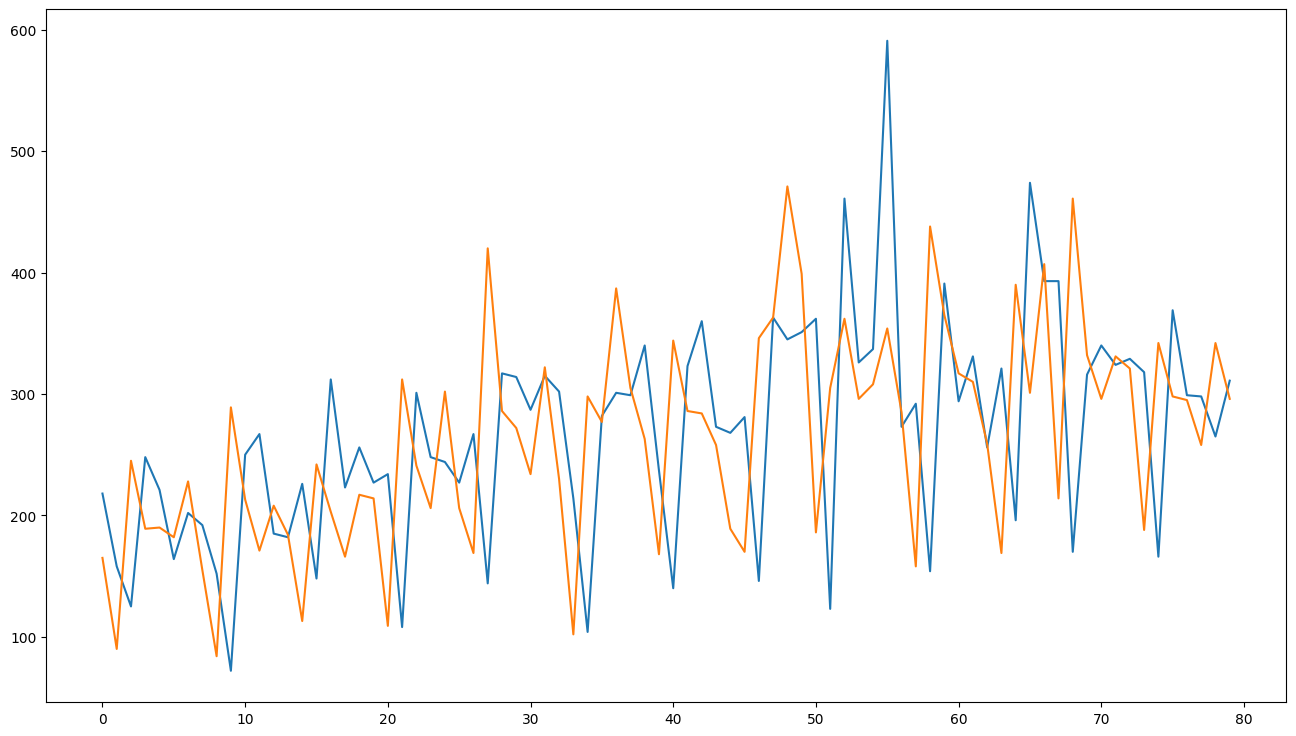

In [37]:
verano2017 = df['2021-06-01':'2021-09-01']
plt.plot(verano2017.values)
verano2018 = df['2022-06-01':'2022-09-01']
plt.plot(verano2018.values)

### Preprocesado los datos

In [44]:
PASOS=7

# convertir series en aprendizaje supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# cargando dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
8,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
9,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
10,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
11,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444


### Dividimos en set de Entrenamiento y Validación

In [45]:
# Dividir en train y conjuntos de prueba.
values = reframed.values
n_train_days = 315+289 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# dividir en entrada y salida
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(567, 1, 7) (567,) (30, 1, 7) (30,)


# Creamos el Modelo de Red Neuronal

### Utilizaremos una Red "normal" Feedforward

In [46]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model


## Entrenamos nuestra máquina

In [47]:
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1, 7)              56        
                                                                 
 flatten_1 (Flatten)         (None, 7)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
81/81 [==============================] - 1s 4ms/step - loss: 0.3171 - mse: 0.1568 - val_loss: 0.2030 - val_mse: 0.0623
Epoch 2/40
81/81 [==============================] - 0s 2ms/step - loss: 0.2529 - mse: 0.0990 - val_loss: 0.1834 - val_mse: 0.0560
Epoch 3/40
81/81 [==============================] - 0s 2ms/step - loss: 0.2196 - mse: 0.0780 - val_loss: 0.1699 - val_mse: 0.0450
Epoch 4/40
81/81 [==============================] - 0s 2ms/step - loss: 0.1956 - mse: 0.0650 - val_loss: 0.1609 - val_mse: 0.0451
Epoch 5/40
81/81 [==============================] - 0s 2ms/step - loss: 0.1823 - mse: 0.0588 - val_loss: 0.1566 - val_mse: 0.0432
Epoch 6/40
81/81 [==============================] - 0s 2ms/step - loss: 0.1766 - mse: 0.0573 - val_loss: 0.1511 - val_mse: 0.0386
Epoch 7/40
81/81 [==============================] - 0s 2ms/step - loss: 0.1752 - mse: 0.0565 - val_loss: 0.1499 - val_mse: 0.0400
Epoch 8/40
81/81 [==============================] - 0s 2ms/step - loss: 0.1721 - mse: 0.05

## Visualizamos Resultados

1/1 [==============================] - 0s 75ms/step
30


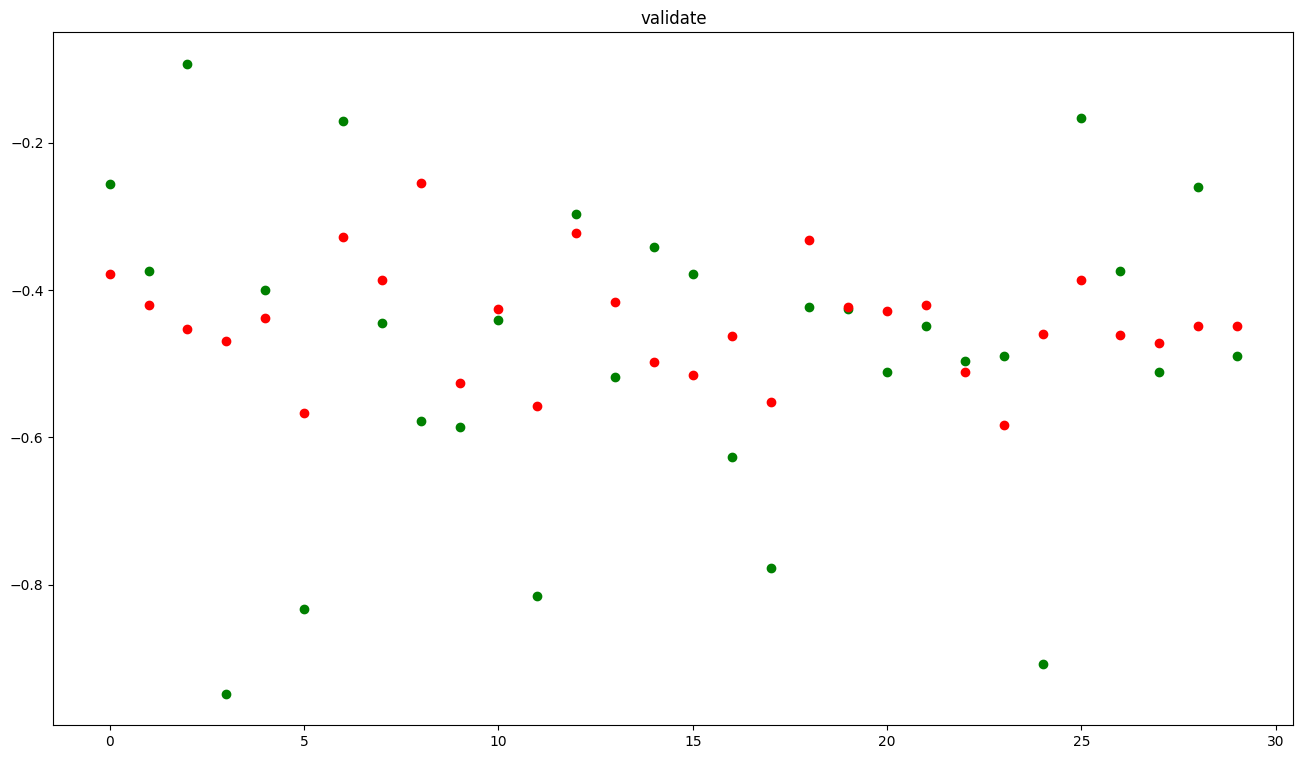

In [48]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()


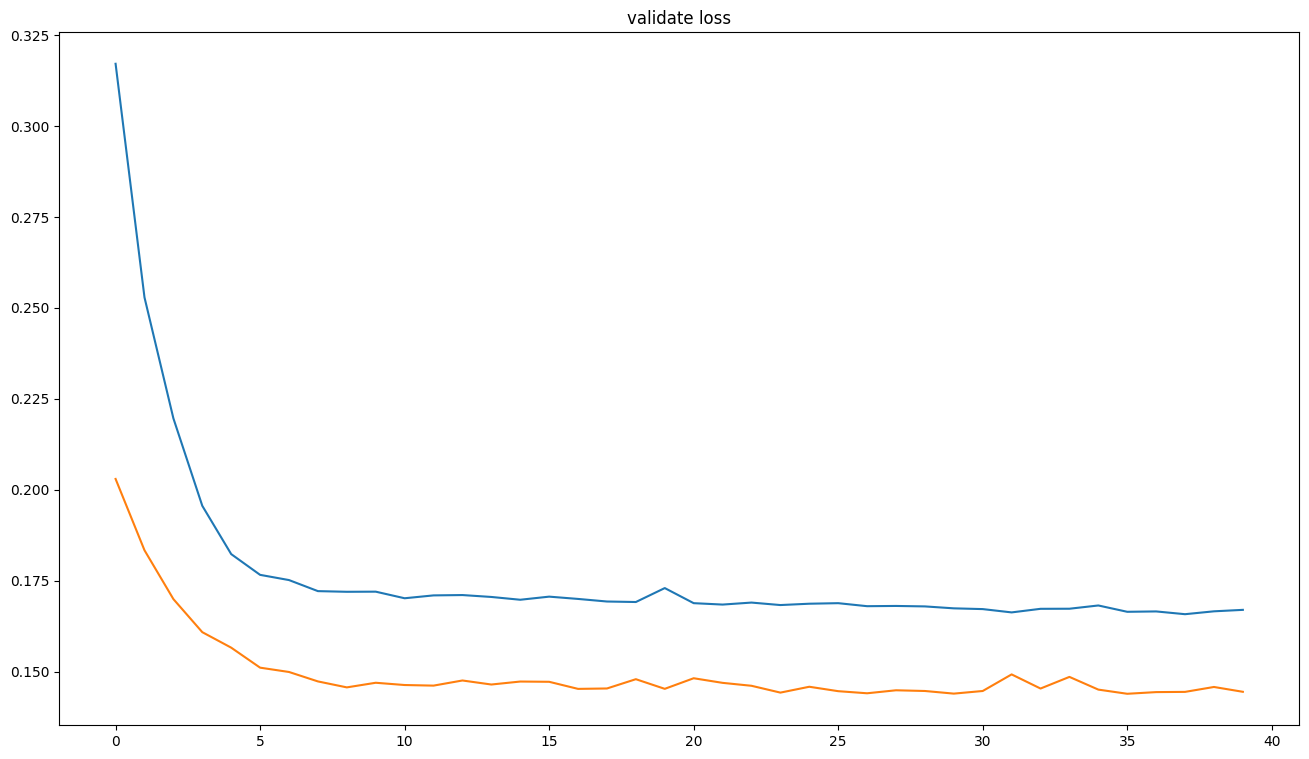

In [49]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

In [50]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head()

,real,prediccion,diferencia
0,252.000000,218.990707,33.009293
1,220.000000,207.508423,12.491577
2,296.000000,198.634201,97.365799
3,64.999992,194.507065,-129.507080
4,213.000000,202.954376,10.045624


In [51]:
compara2.describe()

,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,191.633331,200.954636,-9.321309
std,57.580818,20.759338,51.873558
min,64.999992,163.385483,-129.507080
25%,169.000000,188.350700,-26.927547
50%,200.500000,199.907227,-5.832405
75%,220.000000,208.444576,25.048740
max,296.000000,252.331192,97.365799


<Axes: >

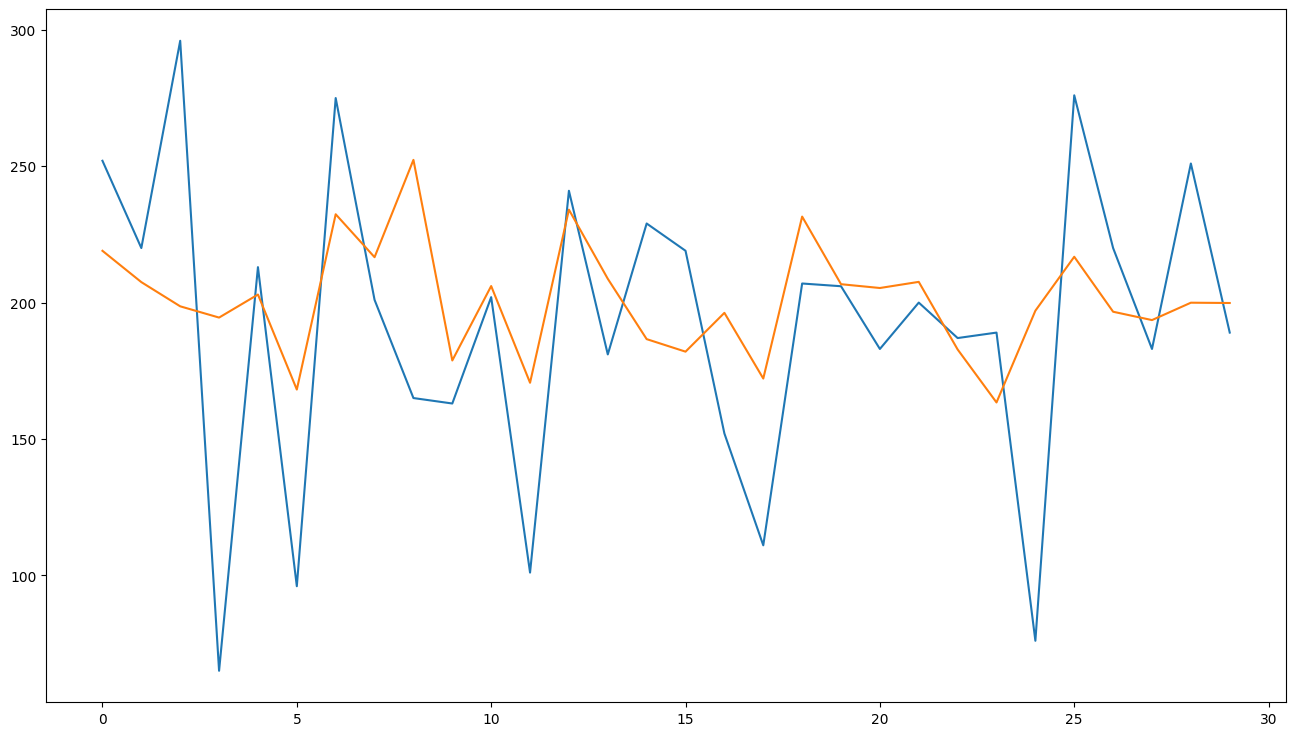

In [52]:
compara2['real'].plot()
compara2['prediccion'].plot()

# Predicción

A partir de la última semana de noviembre 2018, intentaremos predecir la primer semana de diciembre.

In [53]:
ultimosDias = df['2022-11-16':'2022-11-30']
ultimosDias

,unidades
fecha,
2022-11-16,152
2022-11-17,111
2022-11-19,207
2022-11-20,206
2022-11-21,183
2022-11-22,200
2022-11-23,187
2022-11-24,189
2022-11-25,76


## Preparamos los datos para Test

In [54]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.24,-0.65,0.31,0.30,0.07,0.24,0.11
8,-0.65,0.31,0.30,0.07,0.24,0.11,0.13
9,0.31,0.30,0.07,0.24,0.11,0.13,-1.00
10,0.30,0.07,0.24,0.11,0.13,-1.00,1.00
11,0.07,0.24,0.11,0.13,-1.00,1.00,0.44
12,0.24,0.11,0.13,-1.00,1.00,0.44,0.07
13,0.11,0.13,-1.00,1.00,0.44,0.07,0.75


In [55]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[ 0.11000001,  0.13      , -1.        ,  1.        ,
          0.44000006,  0.06999993,  0.75      ]]], dtype=float32)

In [56]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

## Pronóstico para la "próxima semana"

In [57]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])
    

1/1 [==============================] - 0s 30ms/step
[[[ 0.11000001  0.13       -1.          1.          0.44000006
    0.06999993  0.75      ]]]
1/1 [==============================] - 0s 58ms/step
[[[ 0.13       -1.          1.          0.44000006  0.06999993
    0.75       -0.03966523]]]
1/1 [==============================] - 0s 20ms/step
[[[-1.          1.          0.44000006  0.06999993  0.75
   -0.03966523 -0.54480386]]]
1/1 [==============================] - 0s 21ms/step
[[[ 1.          0.44000006  0.06999993  0.75       -0.03966523
   -0.54480386 -0.03150783]]]
1/1 [==============================] - 0s 22ms/step
[[[ 0.44000006  0.06999993  0.75       -0.03966523 -0.54480386
   -0.03150783  0.38699538]]]
1/1 [==============================] - 0s 23ms/step
[[[ 0.06999993  0.75       -0.03966523 -0.54480386 -0.03150783
    0.38699538  0.02420824]]]
1/1 [==============================] - 0s 26ms/step
[[[ 0.75       -0.03966523 -0.54480386 -0.03150783  0.38699538
    0.02420824  0.244

## Re-Convertimos los resultados

In [58]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.03966523], dtype=float32), array([-0.54480386], dtype=float32), array([-0.03150783], dtype=float32), array([0.38699538], dtype=float32), array([0.02420824], dtype=float32), array([0.24481177], dtype=float32), array([-0.09783832], dtype=float32)]


array([[172.0334803 ],
       [121.51961598],
       [172.84922018],
       [214.69954136],
       [178.42082724],
       [200.48118086],
       [166.21617078]])

### Visualizamos el pronóstico

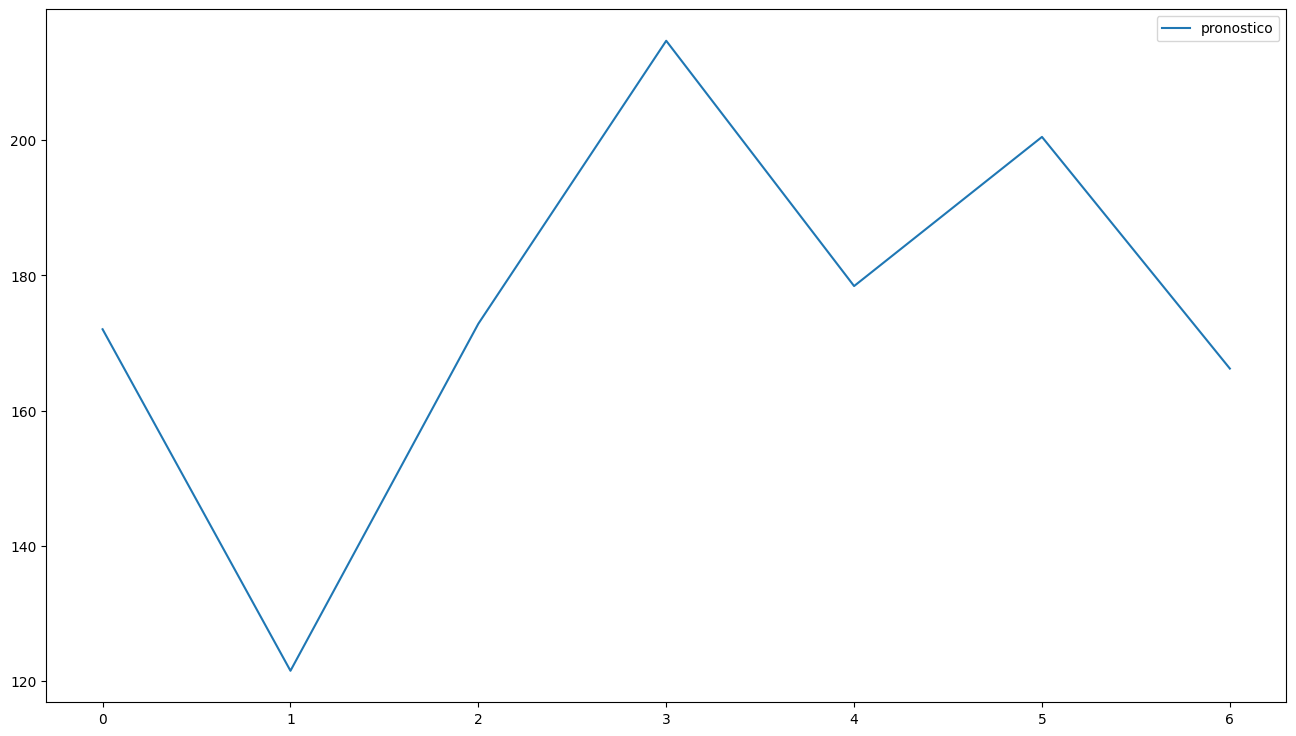

In [59]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico.csv')

In [60]:
prediccion1SemanaDiciembre

,pronostico
0,172.033480
1,121.519616
2,172.849220
3,214.699541
4,178.420827
5,200.481181
6,166.216171


# Agregamos el resultado en el dataset

In [61]:
i=0
for fila in prediccion1SemanaDiciembre.pronostico:
    i=i+1
    ultimosDias.loc['2022-12-0' + str(i) + ' 00:00:00'] = fila
    print(fila)
ultimosDias.tail(14)

172.0334803022477
121.51961598216629
172.84922017565117
214.69954136087466
178.42082724170746
200.48118085744636
166.21617077774192


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_24128\4122539069.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultimosDias.loc['2022-12-0' + str(i) + ' 00:00:00'] = fila
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_24128\4122539069.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultimosDias.loc['2022-12-0' + str(i) + ' 00:00:00'] = fila
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_24128\4122539069.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,unidades
fecha,
2022-11-24 00:00:00,189.000000
2022-11-25 00:00:00,76.000000
2022-11-26 00:00:00,276.000000
2022-11-27 00:00:00,220.000000
2022-11-28 00:00:00,183.000000
2022-11-29 00:00:00,251.000000
2022-11-30 00:00:00,189.000000
2022-12-01 00:00:00,172.033480
2022-12-02 00:00:00,121.519616
